In [2]:
import pandas as pd
import numpy as np
import os
import sys
import keras
import warnings
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf 
import IPython.display as ipd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from IPython.display import Audio
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM,BatchNormalization , GRU
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import SGD
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [3]:
!apt-get update
!apt-get install -y libsndfile1

Get:1 https://packages.cloud.google.com/apt cloud-sdk InRelease [6361 B]
Get:2 https://packages.cloud.google.com/apt google-fast-socket InRelease [5015 B]
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  InRelease [1581 B]
Get:4 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]      
Hit:5 http://archive.ubuntu.com/ubuntu focal InRelease                         
Get:6 https://packages.cloud.google.com/apt cloud-sdk/main amd64 Packages [624 kB]
Get:7 http://archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]        
Get:8 http://packages.cloud.google.com/apt gcsfuse-focal InRelease [1225 B]    
Get:9 https://packages.cloud.google.com/apt google-fast-socket/main amd64 Packages [447 B]
Get:10 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  Packages [1496 kB]
Get:11 http://archive.ubuntu.com/ubuntu focal-backports InRelease [108 kB]
Err:8 http://packages.cloud.google.com/apt gcsfuse-focal InRelease  
  Th

# Importing Dataset

In [4]:
ravdess = "/kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/"
Crema = "/kaggle/input/cremad/AudioWAV/"
Tess = "/kaggle/input/toronto-emotional-speech-set-tess/tess toronto emotional speech set data/TESS Toronto emotional speech set data/"
Savee = "/kaggle/input/surrey-audiovisual-expressed-emotion-savee/ALL/"

# Ryerson Audio-Visual Database of Emotional Speech and Song (RAVDESS) Dataset


In [5]:
file_emotion = []
file_path = []
ravdess_directory_list = os.listdir(ravdess)
for i in ravdess_directory_list:
    actor = os.listdir(ravdess + i)
    for f in actor:
        part = f.split('.')[0].split('-')
        file_emotion.append(int(part[2]))
        file_path.append(ravdess + i + '/' + f)

In [6]:
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])
path_df = pd.DataFrame(file_path, columns=['Path'])
ravdess_df = pd.concat([emotion_df, path_df], axis=1)
ravdess_df.Emotions.replace({1:'neutral', 2:'neutral', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}, inplace=True)

In [7]:
print(ravdess_df.head())

   Emotions                                               Path
0  surprise  /kaggle/input/ravdess-emotional-speech-audio/a...
1   neutral  /kaggle/input/ravdess-emotional-speech-audio/a...
2   disgust  /kaggle/input/ravdess-emotional-speech-audio/a...
3   disgust  /kaggle/input/ravdess-emotional-speech-audio/a...
4   neutral  /kaggle/input/ravdess-emotional-speech-audio/a...


In [8]:
print(ravdess_df.tail())

     Emotions                                               Path
1435     fear  /kaggle/input/ravdess-emotional-speech-audio/a...
1436    angry  /kaggle/input/ravdess-emotional-speech-audio/a...
1437      sad  /kaggle/input/ravdess-emotional-speech-audio/a...
1438  disgust  /kaggle/input/ravdess-emotional-speech-audio/a...
1439    angry  /kaggle/input/ravdess-emotional-speech-audio/a...


In [9]:
print(ravdess_df.Emotions.value_counts())

neutral     288
surprise    192
disgust     192
fear        192
sad         192
happy       192
angry       192
Name: Emotions, dtype: int64


# CREMA-D Dataset

In [10]:
crema_directory_list = os.listdir(Crema)
file_emotion = []
file_path = []
for file in crema_directory_list:
    file_path.append(Crema + file)
    part=file.split('_')
    if part[2] == 'SAD':
        file_emotion.append('sad')
    elif part[2] == 'ANG':
        file_emotion.append('angry')
    elif part[2] == 'DIS':
        file_emotion.append('disgust')
    elif part[2] == 'FEA':
        file_emotion.append('fear')
    elif part[2] == 'HAP':
        file_emotion.append('happy')
    elif part[2] == 'NEU':
        file_emotion.append('neutral')
    else:
        file_emotion.append('Unknown')
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])
path_df = pd.DataFrame(file_path, columns=['Path'])
Crema_df = pd.concat([emotion_df, path_df], axis=1)

In [11]:
Crema_df.head()

,Emotions,Path
0,disgust,/kaggle/input/cremad/AudioWAV/1028_TSI_DIS_XX.wav
1,happy,/kaggle/input/cremad/AudioWAV/1075_IEO_HAP_LO.wav
2,happy,/kaggle/input/cremad/AudioWAV/1084_ITS_HAP_XX.wav
3,disgust,/kaggle/input/cremad/AudioWAV/1067_IWW_DIS_XX.wav
4,disgust,/kaggle/input/cremad/AudioWAV/1066_TIE_DIS_XX.wav


In [12]:
Crema_df.tail()

,Emotions,Path
7437,angry,/kaggle/input/cremad/AudioWAV/1060_IEO_ANG_MD.wav
7438,angry,/kaggle/input/cremad/AudioWAV/1088_IWL_ANG_XX.wav
7439,angry,/kaggle/input/cremad/AudioWAV/1050_IOM_ANG_XX.wav
7440,sad,/kaggle/input/cremad/AudioWAV/1044_IWL_SAD_XX.wav
7441,sad,/kaggle/input/cremad/AudioWAV/1009_ITH_SAD_XX.wav


In [13]:
print(Crema_df.Emotions.value_counts())

disgust    1271
happy      1271
sad        1271
fear       1271
angry      1271
neutral    1087
Name: Emotions, dtype: int64


# Toronto Emotional Speech Set (TESS) Dataset

In [14]:
tess_directory_list = os.listdir(Tess)
file_emotion = []
file_path = []
for dir in tess_directory_list:
    directories = os.listdir(Tess + dir)
    for file in directories:
        part = file.split('.')[0]
        part = part.split('_')[2]
        if part=='ps':
            file_emotion.append('surprise')
        else:
            file_emotion.append(part)
        file_path.append(Tess + dir + '/' + file)
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])
path_df = pd.DataFrame(file_path, columns=['Path'])
Tess_df = pd.concat([emotion_df, path_df], axis=1)

In [15]:
Tess_df.head()

,Emotions,Path
0,fear,/kaggle/input/toronto-emotional-speech-set-tes...
1,fear,/kaggle/input/toronto-emotional-speech-set-tes...
2,fear,/kaggle/input/toronto-emotional-speech-set-tes...
3,fear,/kaggle/input/toronto-emotional-speech-set-tes...
4,fear,/kaggle/input/toronto-emotional-speech-set-tes...


In [16]:
Tess_df.tail()

,Emotions,Path
2795,surprise,/kaggle/input/toronto-emotional-speech-set-tes...
2796,surprise,/kaggle/input/toronto-emotional-speech-set-tes...
2797,surprise,/kaggle/input/toronto-emotional-speech-set-tes...
2798,surprise,/kaggle/input/toronto-emotional-speech-set-tes...
2799,surprise,/kaggle/input/toronto-emotional-speech-set-tes...


In [17]:
print(Tess_df.Emotions.value_counts())

fear        400
angry       400
disgust     400
neutral     400
sad         400
surprise    400
happy       400
Name: Emotions, dtype: int64


# Surrey Audio-Visual Expressed Emotion (SAVEE) Dataset

In [18]:
savee_directory_list = os.listdir(Savee)
file_emotion = []
file_path = []
for file in savee_directory_list:
    file_path.append(Savee + file)
    part = file.split('_')[1]
    ele = part[:-6]
    if ele=='a':
        file_emotion.append('angry')
    elif ele=='d':
        file_emotion.append('disgust')
    elif ele=='f':
        file_emotion.append('fear')
    elif ele=='h':
        file_emotion.append('happy')
    elif ele=='n':
        file_emotion.append('neutral')
    elif ele=='sa':
        file_emotion.append('sad')
    else:
        file_emotion.append('surprise')
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])
path_df = pd.DataFrame(file_path, columns=['Path'])
Savee_df = pd.concat([emotion_df, path_df], axis=1)

In [19]:
Savee_df.head()

,Emotions,Path
0,happy,/kaggle/input/surrey-audiovisual-expressed-emo...
1,fear,/kaggle/input/surrey-audiovisual-expressed-emo...
2,happy,/kaggle/input/surrey-audiovisual-expressed-emo...
3,disgust,/kaggle/input/surrey-audiovisual-expressed-emo...
4,angry,/kaggle/input/surrey-audiovisual-expressed-emo...


In [20]:
Savee_df.tail()

,Emotions,Path
475,surprise,/kaggle/input/surrey-audiovisual-expressed-emo...
476,neutral,/kaggle/input/surrey-audiovisual-expressed-emo...
477,neutral,/kaggle/input/surrey-audiovisual-expressed-emo...
478,angry,/kaggle/input/surrey-audiovisual-expressed-emo...
479,happy,/kaggle/input/surrey-audiovisual-expressed-emo...


In [21]:
print(Savee_df.Emotions.value_counts())

neutral     120
happy        60
fear         60
disgust      60
angry        60
surprise     60
sad          60
Name: Emotions, dtype: int64


# Merging all dataframes into one dataset

In [22]:
data_path = pd.concat([ravdess_df, Crema_df, Tess_df, Savee_df], axis = 0)
data_path.to_csv("data_path.csv",index=False)

In [23]:
data_path.head()

,Emotions,Path
0,surprise,/kaggle/input/ravdess-emotional-speech-audio/a...
1,neutral,/kaggle/input/ravdess-emotional-speech-audio/a...
2,disgust,/kaggle/input/ravdess-emotional-speech-audio/a...
3,disgust,/kaggle/input/ravdess-emotional-speech-audio/a...
4,neutral,/kaggle/input/ravdess-emotional-speech-audio/a...


In [24]:
data_path.tail()

,Emotions,Path
475,surprise,/kaggle/input/surrey-audiovisual-expressed-emo...
476,neutral,/kaggle/input/surrey-audiovisual-expressed-emo...
477,neutral,/kaggle/input/surrey-audiovisual-expressed-emo...
478,angry,/kaggle/input/surrey-audiovisual-expressed-emo...
479,happy,/kaggle/input/surrey-audiovisual-expressed-emo...


In [25]:
print(data_path.Emotions.value_counts())

disgust     1923
fear        1923
sad         1923
happy       1923
angry       1923
neutral     1895
surprise     652
Name: Emotions, dtype: int64


In [26]:
print(len(data_path))

12162


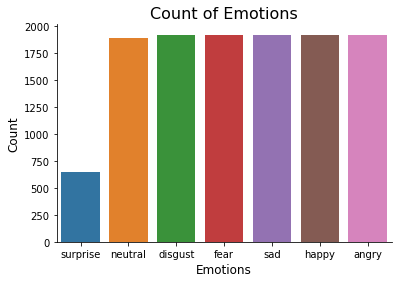

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.title('Count of Emotions', size=16)
sns.countplot(data_path.Emotions)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

In [28]:
data,sr = librosa.load(file_path[0])
sr

22050

In [29]:
ipd.Audio(data,rate=sr)

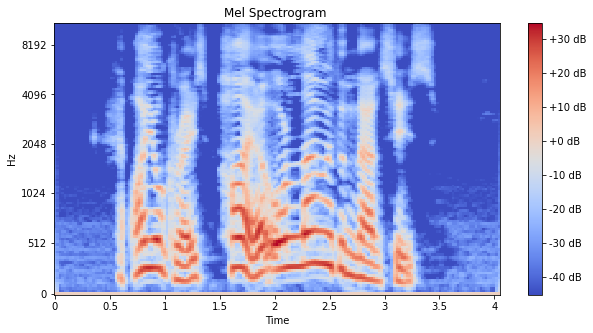

In [30]:
plt.figure(figsize=(10, 5))
spectrogram = librosa.feature.melspectrogram(y=data, sr=sr, n_mels=128,fmax=8000) 
log_spectrogram = librosa.power_to_db(spectrogram)
librosa.display.specshow(log_spectrogram, y_axis='mel', sr=sr, x_axis='time');
plt.title('Mel Spectrogram ')
plt.colorbar(format='%+2.0f dB')

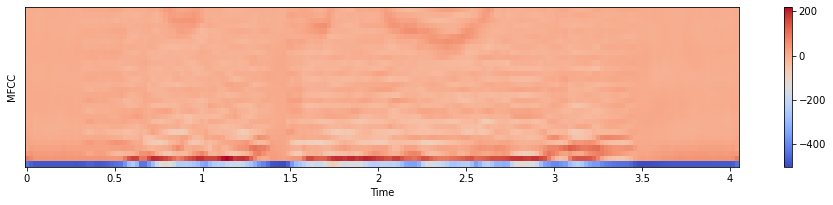

In [31]:
mfcc = librosa.feature.mfcc(y=data, sr=sr, n_mfcc=30)
plt.figure(figsize=(16, 10))
plt.subplot(3,1,1)
librosa.display.specshow(mfcc, x_axis='time')
plt.ylabel('MFCC')
plt.colorbar()
ipd.Audio(data,rate=sr)

# Data Augmentation

In [32]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data
def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate)
def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)
def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)

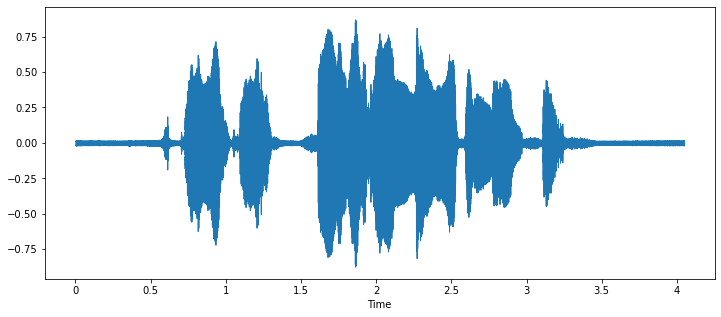

In [33]:
import librosa.display
plt.figure(figsize=(12, 5))
librosa.display.waveshow(y=data, sr=sr)
ipd.Audio(data,rate=sr)

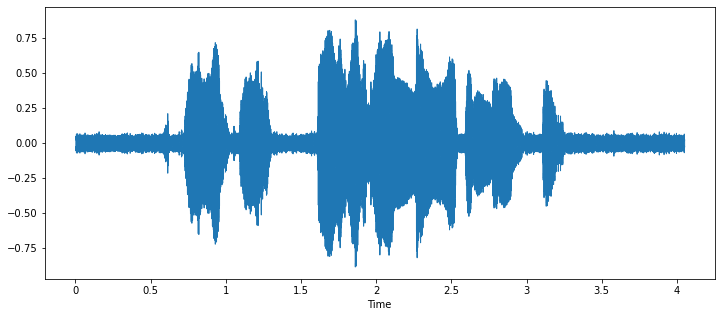

In [34]:
x = noise(data)
plt.figure(figsize=(12,5))
librosa.display.waveshow(y=x, sr=sr)
ipd.Audio(x, rate=sr)

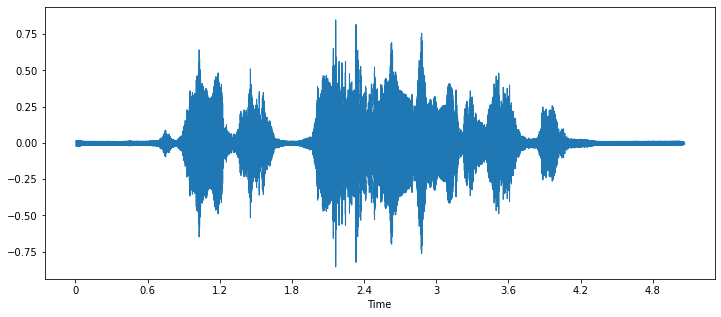

In [35]:
x = stretch(data)
plt.figure(figsize=(12, 5))
librosa.display.waveshow(y=x, sr=sr)
ipd.Audio(x, rate=sr)

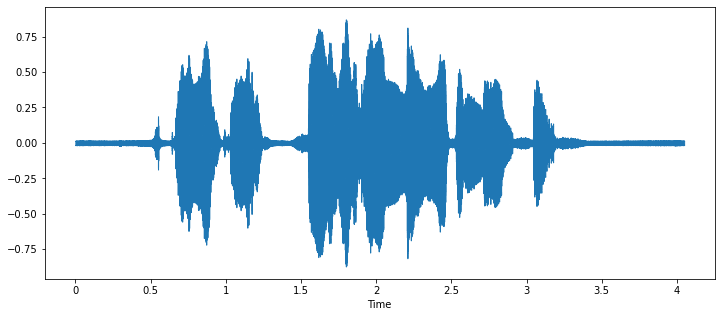

In [36]:
x = shift(data)
plt.figure(figsize=(12,5))
librosa.display.waveshow(y=x, sr=sr)
ipd.Audio(x, rate=sr)

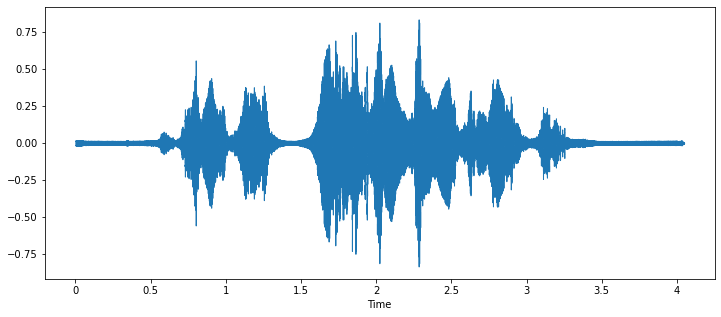

In [37]:
x = pitch(data, sr)
plt.figure(figsize=(12, 5))
librosa.display.waveshow(y=x, sr=sr)
ipd.Audio(x, rate=sr)

# Feature Extraction

## Zero Crossing Rate

In [38]:
def zcr(data,frame_length,hop_length):
    zcr=librosa.feature.zero_crossing_rate(data,frame_length=frame_length,hop_length=hop_length)
    return np.squeeze(zcr)

## Root Mean Square

In [39]:
def rmse(data,frame_length=2048,hop_length=512):
    rmse=librosa.feature.rms(data,frame_length=frame_length,hop_length=hop_length)
    return np.squeeze(rmse)

## Mel Frequency Cepstral Coefficients

In [40]:
def mfcc(data,sr,frame_length=2048,hop_length=512,flatten:bool=True):
    mfcc=librosa.feature.mfcc(data,sr=sr)
    return np.squeeze(mfcc.T)if not flatten else np.ravel(mfcc.T)

In [41]:
def extract_features(data,sr=22050,frame_length=2048,hop_length=512):
    result=np.array([])
    result=np.hstack((result,
                      zcr(data,frame_length,hop_length),
                      rmse(data,frame_length,hop_length),
                      mfcc(data,sr,frame_length,hop_length)
                     ))
    return result

In [42]:
def get_features(path,duration=2.5, offset=0.6):
    data,sr=librosa.load(path,duration=duration,offset=offset)
    aud=extract_features(data)
    audio=np.array(aud)
    noised_audio=noise(data)
    aud2=extract_features(noised_audio)
    audio=np.vstack((audio,aud2))
    pitched_audio=pitch(data,sr)
    aud3=extract_features(pitched_audio)
    audio=np.vstack((audio,aud3))
    pitched_audio1=pitch(data,sr)
    pitched_noised_audio=noise(pitched_audio1)
    aud4=extract_features(pitched_noised_audio)
    audio=np.vstack((audio,aud4))
    return audio

In [43]:
import multiprocessing as mp
print("Number of processors: ", mp.cpu_count())

Number of processors:  4


# Processing Audio 

In [44]:
import timeit
from tqdm import tqdm
start = timeit.default_timer()
X,Y=[],[]
for path,emotion,index in tqdm (zip(data_path.Path,data_path.Emotions,range(data_path.Path.shape[0]))):
    features=get_features(path)
    if index%100==0:
        print(f'{index} audio has been processed currently')
    for i in features:
        X.append(i)
        Y.append(emotion)
print('Audios have been processed sucessfully' )
stop = timeit.default_timer()
print('Time Taken for Processing: ', stop - start)         

1it [00:00,  2.02it/s]

0 audio has been processed currently


101it [00:58,  1.73it/s]

100 audio has been processed currently


201it [01:56,  1.74it/s]

200 audio has been processed currently


301it [02:53,  1.75it/s]

300 audio has been processed currently


401it [03:49,  1.78it/s]

400 audio has been processed currently


501it [04:46,  1.78it/s]

500 audio has been processed currently


601it [05:43,  1.76it/s]

600 audio has been processed currently


701it [06:40,  1.75it/s]

700 audio has been processed currently


801it [07:38,  1.68it/s]

800 audio has been processed currently


901it [08:36,  1.73it/s]

900 audio has been processed currently


1001it [09:34,  1.73it/s]

1000 audio has been processed currently


1101it [10:31,  1.77it/s]

1100 audio has been processed currently


1201it [11:28,  1.77it/s]

1200 audio has been processed currently


1301it [12:25,  1.73it/s]

1300 audio has been processed currently


1401it [13:22,  1.78it/s]

1400 audio has been processed currently


1501it [14:12,  2.24it/s]

1500 audio has been processed currently


1601it [14:57,  2.10it/s]

1600 audio has been processed currently


1701it [15:42,  2.15it/s]

1700 audio has been processed currently


1801it [16:28,  2.06it/s]

1800 audio has been processed currently


1901it [17:13,  2.24it/s]

1900 audio has been processed currently


2001it [17:58,  2.31it/s]

2000 audio has been processed currently


2101it [18:43,  2.19it/s]

2100 audio has been processed currently


2201it [19:29,  2.17it/s]

2200 audio has been processed currently


2301it [20:16,  2.17it/s]

2300 audio has been processed currently


2401it [21:01,  2.17it/s]

2400 audio has been processed currently


2501it [21:47,  2.09it/s]

2500 audio has been processed currently


2601it [22:33,  2.06it/s]

2600 audio has been processed currently


2701it [23:18,  2.18it/s]

2700 audio has been processed currently


2801it [24:03,  2.17it/s]

2800 audio has been processed currently


2901it [24:50,  2.27it/s]

2900 audio has been processed currently


3001it [25:36,  2.12it/s]

3000 audio has been processed currently


3101it [26:22,  2.22it/s]

3100 audio has been processed currently


3201it [27:08,  2.26it/s]

3200 audio has been processed currently


3301it [27:53,  1.97it/s]

3300 audio has been processed currently


3401it [28:39,  2.30it/s]

3400 audio has been processed currently


3501it [29:24,  2.16it/s]

3500 audio has been processed currently


3601it [30:11,  2.12it/s]

3600 audio has been processed currently


3701it [30:56,  2.16it/s]

3700 audio has been processed currently


3801it [31:42,  2.48it/s]

3800 audio has been processed currently


3901it [32:29,  2.08it/s]

3900 audio has been processed currently


4001it [33:16,  2.13it/s]

4000 audio has been processed currently


4101it [34:00,  2.10it/s]

4100 audio has been processed currently


4201it [34:46,  2.31it/s]

4200 audio has been processed currently


4301it [35:32,  2.15it/s]

4300 audio has been processed currently


4401it [36:19,  2.11it/s]

4400 audio has been processed currently


4501it [37:04,  2.31it/s]

4500 audio has been processed currently


4601it [37:50,  2.28it/s]

4600 audio has been processed currently


4701it [38:36,  2.05it/s]

4700 audio has been processed currently


4801it [39:22,  2.21it/s]

4800 audio has been processed currently


4901it [40:08,  2.33it/s]

4900 audio has been processed currently


5001it [40:54,  2.22it/s]

5000 audio has been processed currently


5101it [41:39,  2.27it/s]

5100 audio has been processed currently


5201it [42:25,  2.49it/s]

5200 audio has been processed currently


5301it [43:11,  2.30it/s]

5300 audio has been processed currently


5401it [43:57,  2.03it/s]

5400 audio has been processed currently


5501it [44:42,  2.28it/s]

5500 audio has been processed currently


5601it [45:28,  2.13it/s]

5600 audio has been processed currently


5701it [46:14,  2.13it/s]

5700 audio has been processed currently


5801it [46:59,  2.08it/s]

5800 audio has been processed currently


5901it [47:45,  2.28it/s]

5900 audio has been processed currently


6001it [48:31,  2.09it/s]

6000 audio has been processed currently


6101it [49:17,  2.03it/s]

6100 audio has been processed currently


6201it [50:02,  2.28it/s]

6200 audio has been processed currently


6301it [50:48,  2.27it/s]

6300 audio has been processed currently


6401it [51:34,  2.12it/s]

6400 audio has been processed currently


6501it [52:21,  2.10it/s]

6500 audio has been processed currently


6601it [53:07,  2.20it/s]

6600 audio has been processed currently


6701it [53:52,  2.11it/s]

6700 audio has been processed currently


6801it [54:38,  2.11it/s]

6800 audio has been processed currently


6901it [55:23,  2.12it/s]

6900 audio has been processed currently


7001it [56:10,  2.15it/s]

7000 audio has been processed currently


7101it [56:57,  2.24it/s]

7100 audio has been processed currently


7201it [57:43,  2.30it/s]

7200 audio has been processed currently


7301it [58:29,  2.18it/s]

7300 audio has been processed currently


7401it [59:14,  2.33it/s]

7400 audio has been processed currently


7501it [59:59,  2.10it/s]

7500 audio has been processed currently


7601it [1:00:45,  2.21it/s]

7600 audio has been processed currently


7701it [1:01:31,  2.18it/s]

7700 audio has been processed currently


7801it [1:02:17,  2.12it/s]

7800 audio has been processed currently


7901it [1:03:03,  2.09it/s]

7900 audio has been processed currently


8001it [1:03:48,  2.30it/s]

8000 audio has been processed currently


8101it [1:04:33,  2.09it/s]

8100 audio has been processed currently


8201it [1:05:19,  2.09it/s]

8200 audio has been processed currently


8301it [1:06:05,  2.07it/s]

8300 audio has been processed currently


8401it [1:06:50,  2.21it/s]

8400 audio has been processed currently


8501it [1:07:35,  2.11it/s]

8500 audio has been processed currently


8601it [1:08:20,  2.28it/s]

8600 audio has been processed currently


8701it [1:09:06,  2.08it/s]

8700 audio has been processed currently


8801it [1:09:52,  2.30it/s]

8800 audio has been processed currently


8901it [1:10:37,  2.80it/s]

8900 audio has been processed currently


9001it [1:11:13,  2.32it/s]

9000 audio has been processed currently


9101it [1:11:49,  3.22it/s]

9100 audio has been processed currently


9201it [1:12:21,  3.21it/s]

9200 audio has been processed currently


9301it [1:12:54,  2.96it/s]

9300 audio has been processed currently


9401it [1:13:27,  2.99it/s]

9400 audio has been processed currently


9501it [1:14:03,  2.26it/s]

9500 audio has been processed currently


9601it [1:14:49,  2.27it/s]

9600 audio has been processed currently


9701it [1:15:34,  2.48it/s]

9700 audio has been processed currently


9801it [1:16:15,  2.40it/s]

9800 audio has been processed currently


9901it [1:16:58,  2.36it/s]

9900 audio has been processed currently


10001it [1:17:41,  2.21it/s]

10000 audio has been processed currently


10101it [1:18:24,  2.09it/s]

10100 audio has been processed currently


10201it [1:19:12,  2.07it/s]

10200 audio has been processed currently


10301it [1:20:00,  2.13it/s]

10300 audio has been processed currently


10401it [1:20:48,  2.09it/s]

10400 audio has been processed currently


10501it [1:21:35,  2.40it/s]

10500 audio has been processed currently


10601it [1:22:18,  2.29it/s]

10600 audio has been processed currently


10701it [1:23:00,  2.48it/s]

10700 audio has been processed currently


10801it [1:23:42,  2.35it/s]

10800 audio has been processed currently


10901it [1:24:24,  2.40it/s]

10900 audio has been processed currently


11001it [1:25:05,  2.42it/s]

11000 audio has been processed currently


11101it [1:25:45,  2.32it/s]

11100 audio has been processed currently


11201it [1:26:26,  2.37it/s]

11200 audio has been processed currently


11301it [1:27:09,  2.18it/s]

11300 audio has been processed currently


11401it [1:27:55,  2.13it/s]

11400 audio has been processed currently


11501it [1:28:43,  2.39it/s]

11500 audio has been processed currently


11601it [1:29:25,  2.37it/s]

11600 audio has been processed currently


11701it [1:30:09,  1.86it/s]

11700 audio has been processed currently


11801it [1:31:04,  1.73it/s]

11800 audio has been processed currently


11901it [1:32:00,  1.78it/s]

11900 audio has been processed currently


12001it [1:32:55,  1.85it/s]

12000 audio has been processed currently


12101it [1:33:48,  1.86it/s]

12100 audio has been processed currently


12162it [1:34:22,  2.15it/s]

Audios have been processed sucessfully
Time Taken for Processing:  5662.248324436


In [45]:
len(X), len(Y), data_path.Path.shape

(48648, 48648, (12162,))

# Saving Features

In [46]:
Emotions = pd.DataFrame(X)
Emotions['Emotions'] = Y
Emotions.to_csv('emotion.csv', index=False)

In [47]:
Emotions.head()

,0,1,2,3,4,5,6,7,8,9,...,2367,2368,2369,2370,2371,2372,2373,2374,2375,Emotions
0,0.331543,0.471680,0.564941,0.452148,0.374512,0.296875,0.265137,0.256348,0.252441,0.251953,...,-1.517647,-1.716411,-1.599245,-1.234544,-0.693115,-0.038821,0.675410,1.405862,2.112551,surprise
1,0.245605,0.375488,0.499512,0.487793,0.491211,0.486328,0.483398,0.491699,0.496582,0.504883,...,1.813650,-0.763576,-1.183623,-1.319409,-3.888916,-0.077988,1.506448,0.917143,-2.321661,surprise
2,0.299805,0.419922,0.525879,0.459473,0.378418,0.326172,0.282227,0.260254,0.258789,0.253906,...,0.518931,0.839123,1.308965,1.855116,2.404975,2.896071,3.282977,3.541091,3.666846,surprise
3,0.252441,0.377441,0.501465,0.514648,0.504395,0.507324,0.508301,0.503906,0.508301,0.500977,...,1.752874,-3.369907,-3.678613,-3.432711,0.030161,0.039836,-4.197558,0.161075,0.184426,surprise
4,0.400879,0.591309,0.783203,0.777832,0.771973,0.777832,0.771973,0.775391,0.758789,0.580078,...,2.585884,2.746578,2.223155,0.986784,-0.730886,-2.531058,-4.002848,-4.849192,-4.929412,neutral


In [48]:
Emotions.tail()

,0,1,2,3,4,5,6,7,8,9,...,2367,2368,2369,2370,2371,2372,2373,2374,2375,Emotions
48643,0.022949,0.039551,0.054199,0.053711,0.049805,0.039062,0.040039,0.055664,0.062988,0.070801,...,4.031071,4.655960,5.011063,-1.155820,1.858171,0.432247,0.149648,3.410618,9.694407,angry
48644,0.023926,0.035156,0.040527,0.035645,0.032715,0.029297,0.032715,0.048340,0.125488,0.214844,...,-5.741303,-4.147367,-7.531296,-3.492056,-2.512284,-11.724421,-7.290385,1.041335,1.246792,happy
48645,0.026855,0.066406,0.104004,0.129395,0.125488,0.094727,0.070801,0.074707,0.160645,0.254883,...,-10.433143,-6.022792,-4.793187,-2.507638,-4.705285,-3.992453,-1.611762,-1.760060,-3.403010,happy
48646,0.022461,0.034668,0.041992,0.038086,0.038086,0.034668,0.036133,0.044434,0.117676,0.207031,...,-4.208821,3.741515,-2.212302,1.554489,-3.257357,-17.360344,-1.698289,6.971028,-4.712042,happy
48647,0.024414,0.046387,0.062500,0.067383,0.074219,0.062012,0.055664,0.057129,0.124512,0.216309,...,-4.940582,-1.860461,0.095156,1.915736,-2.243130,-6.756801,-5.046906,-7.670960,-10.312390,happy


In [49]:
Emotions = pd.read_csv('./emotion.csv')

In [50]:
Emotions.head()

,0,1,2,3,4,5,6,7,8,9,...,2367,2368,2369,2370,2371,2372,2373,2374,2375,Emotions
0,0.331543,0.471680,0.564941,0.452148,0.374512,0.296875,0.265137,0.256348,0.252441,0.251953,...,-1.517647,-1.716411,-1.599245,-1.234544,-0.693115,-0.038821,0.675410,1.405862,2.112551,surprise
1,0.245605,0.375488,0.499512,0.487793,0.491211,0.486328,0.483398,0.491699,0.496582,0.504883,...,1.813650,-0.763576,-1.183623,-1.319409,-3.888916,-0.077988,1.506448,0.917143,-2.321661,surprise
2,0.299805,0.419922,0.525879,0.459473,0.378418,0.326172,0.282227,0.260254,0.258789,0.253906,...,0.518931,0.839123,1.308965,1.855116,2.404975,2.896071,3.282977,3.541091,3.666846,surprise
3,0.252441,0.377441,0.501465,0.514648,0.504395,0.507324,0.508301,0.503906,0.508301,0.500977,...,1.752874,-3.369907,-3.678613,-3.432711,0.030161,0.039836,-4.197558,0.161075,0.184426,surprise
4,0.400879,0.591309,0.783203,0.777832,0.771973,0.777832,0.771973,0.775391,0.758789,0.580078,...,2.585884,2.746578,2.223155,0.986784,-0.730886,-2.531058,-4.002848,-4.849192,-4.929412,neutral


In [51]:
Emotions.tail()

,0,1,2,3,4,5,6,7,8,9,...,2367,2368,2369,2370,2371,2372,2373,2374,2375,Emotions
48643,0.022949,0.039551,0.054199,0.053711,0.049805,0.039062,0.040039,0.055664,0.062988,0.070801,...,4.031071,4.655960,5.011063,-1.155820,1.858171,0.432247,0.149648,3.410618,9.694407,angry
48644,0.023926,0.035156,0.040527,0.035645,0.032715,0.029297,0.032715,0.048340,0.125488,0.214844,...,-5.741303,-4.147367,-7.531296,-3.492056,-2.512284,-11.724421,-7.290385,1.041335,1.246792,happy
48645,0.026855,0.066406,0.104004,0.129395,0.125488,0.094727,0.070801,0.074707,0.160645,0.254883,...,-10.433143,-6.022792,-4.793187,-2.507638,-4.705285,-3.992453,-1.611762,-1.760060,-3.403010,happy
48646,0.022461,0.034668,0.041992,0.038086,0.038086,0.034668,0.036133,0.044434,0.117676,0.207031,...,-4.208821,3.741515,-2.212302,1.554489,-3.257357,-17.360344,-1.698289,6.971028,-4.712042,happy
48647,0.024414,0.046387,0.062500,0.067383,0.074219,0.062012,0.055664,0.057129,0.124512,0.216309,...,-4.940582,-1.860461,0.095156,1.915736,-2.243130,-6.756801,-5.046906,-7.670960,-10.312390,happy


In [52]:
print(Emotions.isna().any())

0           False
1           False
2           False
3           False
4           False
            ...  
2372         True
2373         True
2374         True
2375         True
Emotions    False
Length: 2377, dtype: bool


In [53]:
Emotions=Emotions.fillna(0)
print(Emotions.isna().any())

0           False
1           False
2           False
3           False
4           False
            ...  
2372        False
2373        False
2374        False
2375        False
Emotions    False
Length: 2377, dtype: bool


In [54]:
Emotions.shape

(48648, 2377)

In [55]:
np.sum(Emotions.isna())

0           0
1           0
2           0
3           0
4           0
           ..
2372        0
2373        0
2374        0
2375        0
Emotions    0
Length: 2377, dtype: int64

# Data preparation

In [56]:
X = Emotions.iloc[: ,:-1].values
Y = Emotions['Emotions'].values

In [57]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [58]:
print(Y.shape)

(48648, 7)


In [59]:
print(X.shape)

(48648, 2376)


In [60]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=42,test_size=0.2, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((38918, 2376), (38918, 7), (9730, 2376), (9730, 7))

In [61]:
X_train = x_train.reshape(x_train.shape[0] , x_train.shape[1] , 1)
X_test = x_test.reshape(x_test.shape[0] , x_test.shape[1] , 1)

In [62]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((38918, 2376), (38918, 7), (9730, 2376), (9730, 7))

In [63]:
import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM,BatchNormalization , GRU
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import SGD

In [64]:
from keras.callbacks import ModelCheckpoint, EarlyStopping,ReduceLROnPlateau
model_checkpoint = ModelCheckpoint('best_model1_weights.h5', monitor='val_accuracy', save_best_only=True)

In [65]:
early_stop=EarlyStopping(monitor='val_acc',mode='auto',patience=5,restore_best_weights=True)
lr_reduction=ReduceLROnPlateau(monitor='val_acc',patience=3,verbose=1,factor=0.5,min_lr=0.00001)

# CNN model

In [66]:
x_traincnn =np.expand_dims(x_train, axis=2)
x_testcnn= np.expand_dims(x_test, axis=2)
x_traincnn.shape, y_train.shape, x_testcnn.shape, y_test.shape

((38918, 2376, 1), (38918, 7), (9730, 2376, 1), (9730, 7))

In [67]:
import tensorflow.keras.layers as L
model = tf.keras.Sequential([
    L.Conv1D(512,kernel_size=5, strides=1,padding='same', activation='relu',input_shape=(X_train.shape[1],1)),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5,strides=2,padding='same'),
    L.Conv1D(512,kernel_size=5,strides=1,padding='same',activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5,strides=2,padding='same'),
    Dropout(0.2),  
    L.Conv1D(256,kernel_size=5,strides=1,padding='same',activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5,strides=2,padding='same'),
    L.Conv1D(256,kernel_size=3,strides=1,padding='same',activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5,strides=2,padding='same'),
    Dropout(0.2),
    L.Conv1D(128,kernel_size=3,strides=1,padding='same',activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=3,strides=2,padding='same'),
    Dropout(0.2),
    L.Flatten(),
    L.Dense(512,activation='relu'),
    L.BatchNormalization(),
    L.Dense(7,activation='softmax')
])
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics='accuracy')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 2376, 512)         3072      
_________________________________________________________________
batch_normalization (BatchNo (None, 2376, 512)         2048      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 1188, 512)         0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1188, 512)         1311232   
_________________________________________________________________
batch_normalization_1 (Batch (None, 1188, 512)         2048      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 594, 512)          0         
_________________________________________________________________
dropout (Dropout)            (None, 594, 512)          0

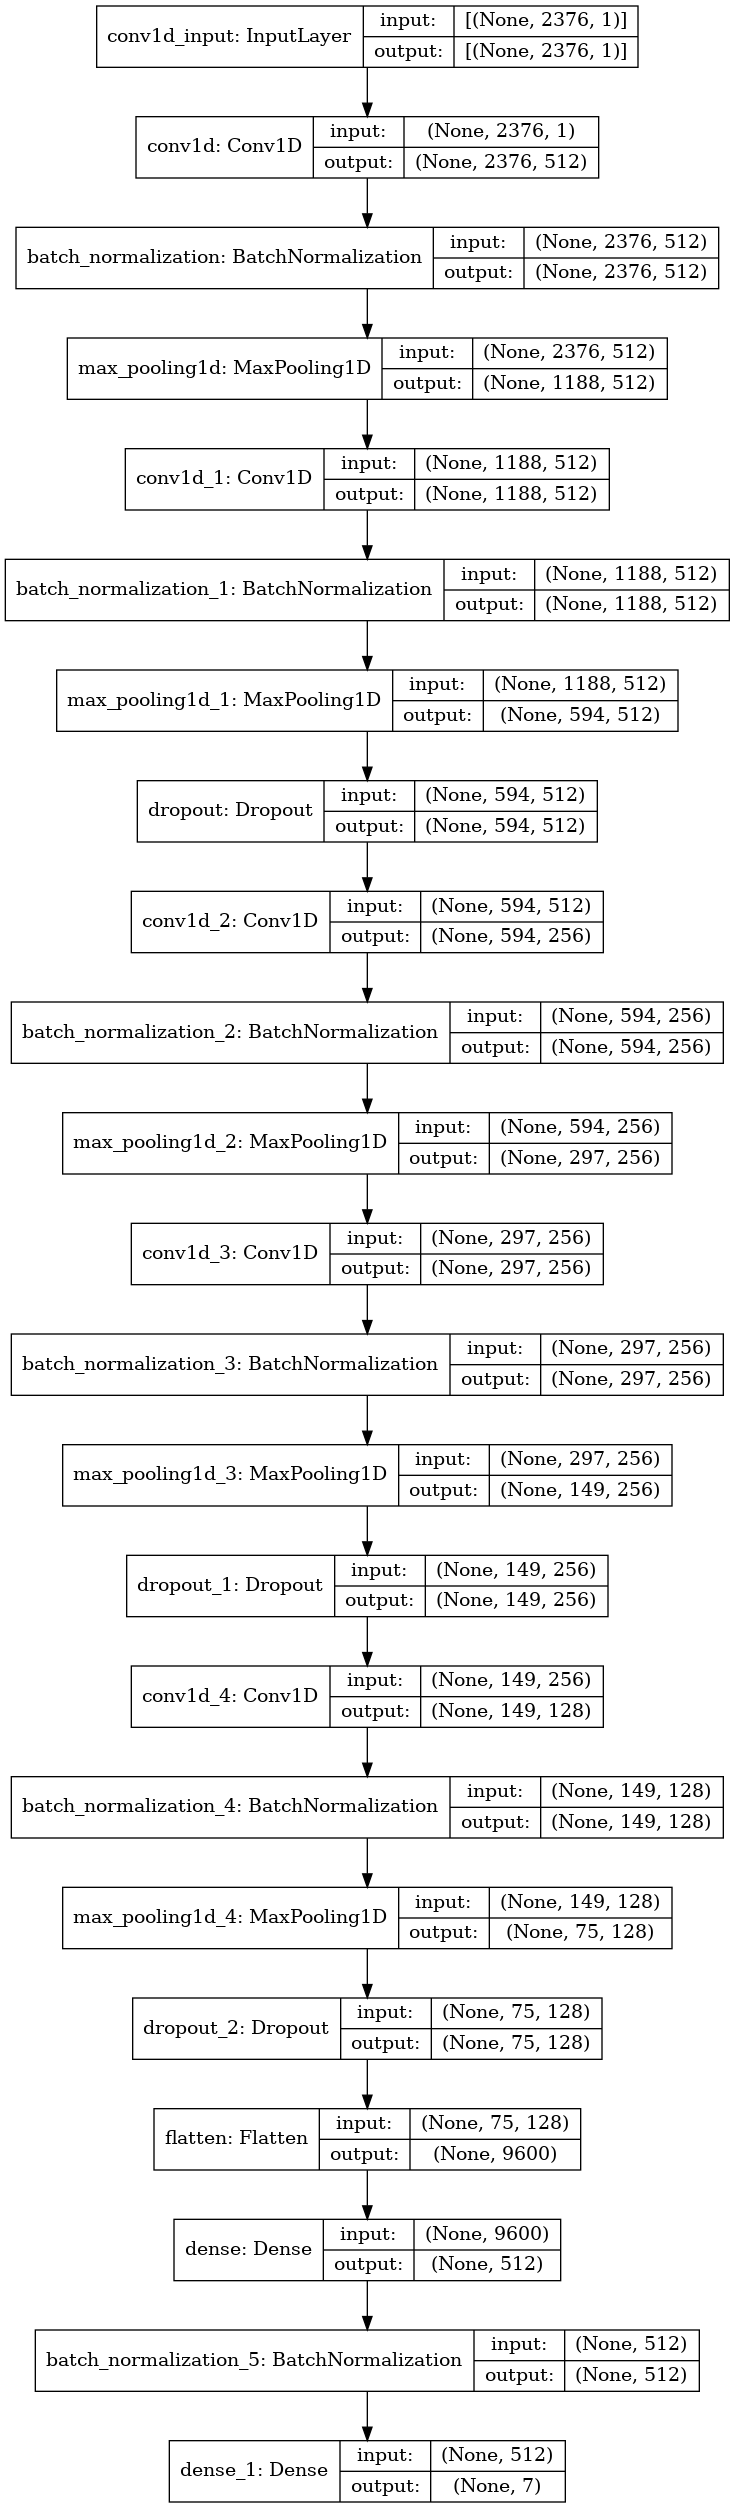

In [68]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [69]:
history=model.fit(x_traincnn, y_train, epochs=50, validation_data=(x_testcnn, y_test), batch_size=64,callbacks=[early_stop,lr_reduction,model_checkpoint])

Epoch 1/50
609/609 [==============================] - 115s 174ms/step - loss: 1.3940 - accuracy: 0.4657 - val_loss: 1.2950 - val_accuracy: 0.4845
Epoch 2/50
609/609 [==============================] - 105s 173ms/step - loss: 1.1057 - accuracy: 0.5703 - val_loss: 1.6153 - val_accuracy: 0.4497
Epoch 3/50
609/609 [==============================] - 105s 173ms/step - loss: 1.0068 - accuracy: 0.6125 - val_loss: 1.0616 - val_accuracy: 0.5975
Epoch 4/50
609/609 [==============================] - 105s 173ms/step - loss: 0.8698 - accuracy: 0.6673 - val_loss: 0.9577 - val_accuracy: 0.6418
Epoch 5/50
609/609 [==============================] - 105s 172ms/step - loss: 0.7572 - accuracy: 0.7123 - val_loss: 0.8625 - val_accuracy: 0.6900
Epoch 6/50
609/609 [==============================] - 105s 172ms/step - loss: 0.6382 - accuracy: 0.7638 - val_loss: 0.6979 - val_accuracy: 0.7383
Epoch 7/50
609/609 [==============================] - 105s 173ms/step - loss: 0.5045 - accuracy: 0.8163 - val_loss: 0.6510 -

# Evalutation of CNN Model

In [70]:
print("Accuracy of our CNN model: " , model.evaluate(x_testcnn,y_test)[1]*100 , "%")

305/305 [==============================] - 7s 23ms/step - loss: 0.1278 - accuracy: 0.9683
Accuracy of our CNN model:  96.83453440666199 %


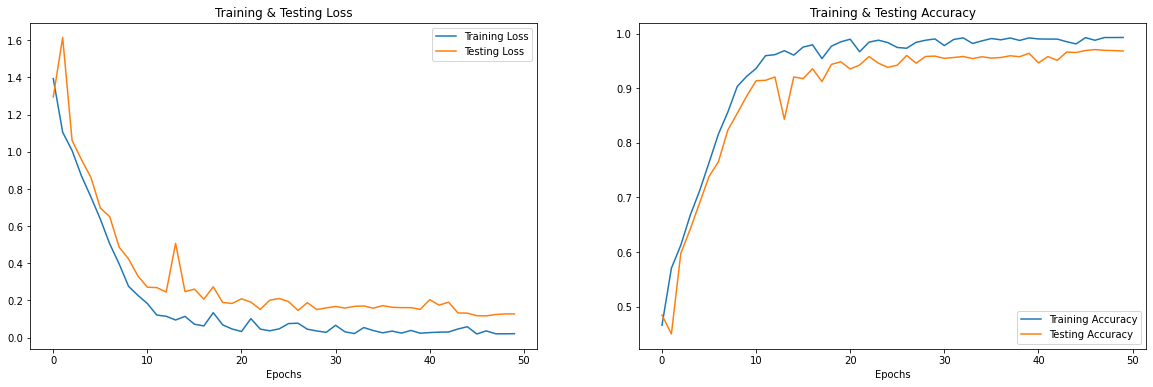

In [71]:
epochs = [i for i in range(50)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']
fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [72]:
pred_test0 = model.predict(x_testcnn)
y_pred0 = encoder.inverse_transform(pred_test0)
y_test0 = encoder.inverse_transform(y_test)
df0 = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df0['Predicted Labels'] = y_pred0.flatten()
df0['Actual Labels'] = y_test0.flatten()

In [73]:
df0.head(10)

,Predicted Labels,Actual Labels
0,angry,angry
1,angry,angry
2,disgust,disgust
3,happy,happy
4,fear,fear
5,happy,happy
6,happy,happy
7,fear,fear
8,fear,fear
9,surprise,surprise


In [74]:
df0.tail(10)

,Predicted Labels,Actual Labels
9720,happy,happy
9721,angry,angry
9722,sad,sad
9723,fear,fear
9724,angry,angry
9725,fear,fear
9726,disgust,disgust
9727,neutral,neutral
9728,sad,sad
9729,fear,fear


In [75]:
df0

,Predicted Labels,Actual Labels
0,angry,angry
1,angry,angry
2,disgust,disgust
3,happy,happy
4,fear,fear
...,...,...
9725,fear,fear
9726,disgust,disgust
9727,neutral,neutral
9728,sad,sad


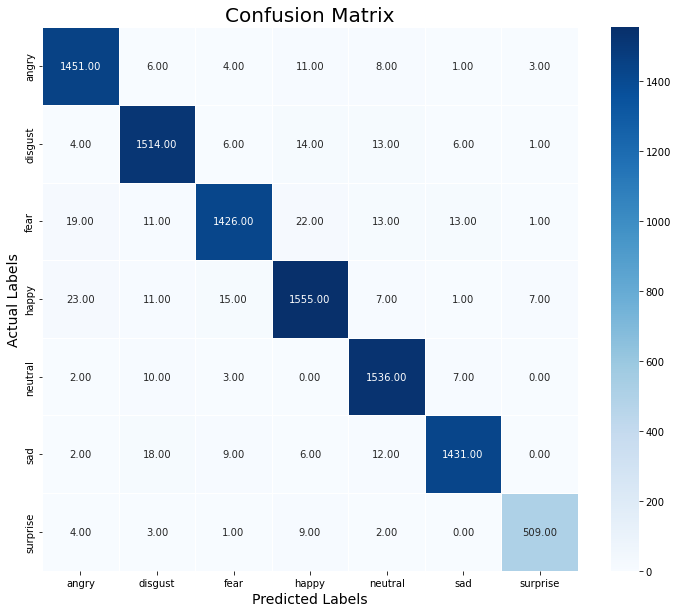

In [76]:
from sklearn.metrics import confusion_matrix,classification_report
cm = confusion_matrix(y_test0, y_pred0)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='.2f')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [77]:
print(classification_report(y_test0, y_pred0))

              precision    recall  f1-score   support

       angry       0.96      0.98      0.97      1484
     disgust       0.96      0.97      0.97      1558
        fear       0.97      0.95      0.96      1505
       happy       0.96      0.96      0.96      1619
     neutral       0.97      0.99      0.98      1558
         sad       0.98      0.97      0.97      1478
    surprise       0.98      0.96      0.97       528

    accuracy                           0.97      9730
   macro avg       0.97      0.97      0.97      9730
weighted avg       0.97      0.97      0.97      9730



# Saving Model 

In [78]:
from tensorflow.keras.models import Sequential, model_from_json
model_json = model.to_json()
with open("CNN_model.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("CNN_model_weights.h5")
print("Saved model to disk") 

Saved model to disk


In [79]:
from tensorflow.keras.models import Sequential, model_from_json
json_file = open('/kaggle/working/CNN_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
loaded_model.load_weights("/kaggle/working/best_model1_weights.h5")
print("Loaded model from disk")

Loaded model from disk


In [80]:
loaded_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
score = loaded_model.evaluate(x_testcnn,y_test)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

305/305 [==============================] - 7s 23ms/step - loss: 0.1172 - accuracy: 0.9710
accuracy: 97.10%


# Saving and Loading our Standrad Scaler and encoder

In [81]:
import pickle
with open('scaler2.pickle', 'wb') as f:
    pickle.dump(scaler, f)
with open('scaler2.pickle', 'rb') as f:
    scaler2 = pickle.load(f)
with open('encoder2.pickle', 'wb') as f:
    pickle.dump(encoder, f)
with open('encoder2.pickle', 'rb') as f:
    encoder2 = pickle.load(f)    

# Testing


In [82]:
from tensorflow.keras.models import Sequential, model_from_json
json_file = open('/kaggle/working/CNN_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
loaded_model.load_weights("/kaggle/working/best_model1_weights.h5")
print("Loaded model from disk")

Loaded model from disk


In [83]:
import pickle
with open('/kaggle/working/scaler2.pickle', 'rb') as f:
    scaler2 = pickle.load(f)
with open('/kaggle/working/encoder2.pickle', 'rb') as f:
    encoder2 = pickle.load(f)   

In [84]:
import librosa

In [85]:
def zcr(data,frame_length,hop_length):
    zcr=librosa.feature.zero_crossing_rate(data,frame_length=frame_length,hop_length=hop_length)
    return np.squeeze(zcr)
def rmse(data,frame_length=2048,hop_length=512):
    rmse=librosa.feature.rms(data,frame_length=frame_length,hop_length=hop_length)
    return np.squeeze(rmse)
def mfcc(data,sr,frame_length=2048,hop_length=512,flatten:bool=True):
    mfcc=librosa.feature.mfcc(data,sr=sr)
    return np.squeeze(mfcc.T)if not flatten else np.ravel(mfcc.T)
def extract_features(data,sr=22050,frame_length=2048,hop_length=512):
    result=np.array([])
    result=np.hstack((result,
                      zcr(data,frame_length,hop_length),
                      rmse(data,frame_length,hop_length),
                      mfcc(data,sr,frame_length,hop_length)
                     ))
    return result

In [86]:
def get_predict_feat(path):
    d, s_rate= librosa.load(path, duration=2.5, offset=0.6)
    res=extract_features(d)
    result=np.array(res)
    result=np.reshape(result,newshape=(1,2376))
    i_result = scaler2.transform(result)
    final_result=np.expand_dims(i_result, axis=2)
    return final_result

In [87]:
res=get_predict_feat("/kaggle/input/ravdess-emotional-speech-audio/Actor_01/03-01-07-01-01-01-01.wav")
print(res.shape)

(1, 2376, 1)


In [88]:
emotions1={1:'Neutral', 2:'Calm', 3:'Happy', 4:'Sad', 5:'Angry', 6:'Fear', 7:'Disgust',8:'Surprise'}
def prediction(path1):
    res=get_predict_feat(path1)
    predictions=loaded_model.predict(res)
    y_pred = encoder2.inverse_transform(predictions)
    print(y_pred[0][0])    

In [89]:
prediction("/kaggle/input/ravdess-emotional-speech-audio/Actor_02/03-01-01-01-01-01-02.wav")

neutral


In [90]:
prediction("/kaggle/input/ravdess-emotional-speech-audio/Actor_01/03-01-01-01-01-01-01.wav")

neutral


In [91]:
prediction("/kaggle/input/ravdess-emotional-speech-audio/Actor_01/03-01-05-01-02-02-01.wav")

angry


In [92]:
prediction("/kaggle/input/ravdess-emotional-speech-audio/Actor_21/03-01-04-02-02-02-21.wav")

sad


In [93]:
prediction("/kaggle/input/ravdess-emotional-speech-audio/Actor_02/03-01-06-01-02-02-02.wav")

fear


In [94]:
prediction("/kaggle/input/ravdess-emotional-speech-audio/Actor_01/03-01-08-01-01-01-01.wav")

surprise


In [95]:
prediction("/kaggle/input/ravdess-emotional-speech-audio/Actor_01/03-01-07-01-01-01-01.wav")

disgust


In [96]:
prediction("/kaggle/input/manual-testing/AUDIO-2024-04-05-21-21-38-1.m4a")

angry


In [97]:
prediction("/kaggle/input/manual-testing/AUDIO-2024-04-05-21-21-38.m4a")

fear


In [98]:
prediction("/kaggle/input/manual-testing/AUDIO-2024-04-05-21-22-33.m4a")

disgust


In [99]:
prediction("/kaggle/input/manual-testing/AUDIO-2024-04-05-21-22-47.m4a")

neutral


In [101]:
prediction("/kaggle/input/manual-testing/AUDIO-2024-04-05-02-26-31.m4a")

sad


In [103]:
import glob
import os
import librosa
import time
import seaborn as sns
import numpy as np
import pandas as pd
from tqdm import tqdm

In [104]:
def extract_feature(file_name):
    
    X, sample_rate = librosa.load(os.path.join(file_name), res_type='kaiser_fast')
    result = np.array([])
    
    stft = np.abs(librosa.stft(X))
    chromas = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chromas))

    mfccs=np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0)
    result=np.hstack((result, mfccs))

    mels = np.mean(librosa.feature.melspectrogram(y=X, sr=sample_rate, n_mels=128).T, axis=0)
    result = np.hstack((result, mels))
        
    return result
    

In [105]:
def load_data(): 
    sound, emo =[],[]

    for file in glob.glob("/kaggle/input/toronto-emotional-speech-set-tess/tess toronto emotional speech set data/TESS Toronto emotional speech set data/*AF_*/*.wav"):
        file_name=os.path.basename(file)
        emotion=file_name.split("_")[2][:-4]
        sound.append(file)
        emo.append(emotion)
        
    return {"file": sound, "emotion": emo}

In [106]:
start_time = time.time()

Trial_dict = load_data()

print("--- Data loaded. Loading time: %s seconds ---" % (time.time() - start_time))

--- Data loaded. Loading time: 0.030559778213500977 seconds ---


In [107]:
X = pd.DataFrame(Trial_dict["file"])
y = pd.DataFrame(Trial_dict["emotion"])

In [108]:
X.shape, y.shape

((2800, 1), (2800, 1))

In [109]:
y.value_counts()

angry      400
disgust    400
fear       400
happy      400
neutral    400
ps         400
sad        400
dtype: int64

In [110]:
X_features =[]

for x in tqdm(X[0]):
#     print(x)
    X_features.append(extract_feature(x))

100%|██████████| 2800/2800 [03:30<00:00, 13.27it/s]


In [111]:
X_features = pd.DataFrame(X_features)

In [112]:
y=y.rename(columns= {0: 'emotion'})

In [113]:
data = pd.concat([X_features, y], axis =1)

In [114]:
data = data.reindex(np.random.permutation(data.index))

In [115]:
data.to_csv("TESS_FEATURES.csv")

In [116]:
starting_time = time.time()
data = pd.read_csv("./TESS_FEATURES.csv")
print("data loaded in " + str(time.time()-starting_time) + "ms")

print(data.head())

data loaded in 0.14663982391357422ms
   Unnamed: 0         0         1         2         3         4         5  \
0        2360  0.441710  0.453048  0.423523  0.386367  0.410614  0.571454   
1        1069  0.480835  0.522532  0.529001  0.393620  0.373615  0.390352   
2        1393  0.419723  0.386518  0.320326  0.299735  0.332713  0.374680   
3        1783  0.475847  0.788877  0.516959  0.301095  0.355510  0.475091   
4        1677  0.391040  0.381331  0.486420  0.284580  0.225128  0.293380   

          6         7         8  ...       171       172       173       174  \
0  0.593871  0.515533  0.499693  ...  0.000277  0.000283  0.000235  0.000206   
1  0.400814  0.478829  0.428985  ...  0.026365  0.031173  0.019853  0.007092   
2  0.475159  0.464743  0.477454  ...  0.000096  0.000048  0.000028  0.000029   
3  0.833790  0.586229  0.365570  ...  0.005935  0.004887  0.002994  0.001935   
4  0.496245  0.869974  0.514235  ...  0.003892  0.003118  0.002411  0.001080   

        175       1

In [117]:
data.shape

(2800, 182)

In [118]:
data.columns

Index(['Unnamed: 0', '0', '1', '2', '3', '4', '5', '6', '7', '8',
       ...
       '171', '172', '173', '174', '175', '176', '177', '178', '179',
       'emotion'],
      dtype='object', length=182)

In [119]:
data = data.drop('Unnamed: 0',axis=1)

In [120]:
data.columns

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
       ...
       '171', '172', '173', '174', '175', '176', '177', '178', '179',
       'emotion'],
      dtype='object', length=181)

In [121]:
X = data.drop('emotion', axis = 1).values
y = data['emotion'].values

In [122]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [123]:
X.shape, y.shape

((2800, 180), (2800,))

In [124]:
np.unique(y)

array(['angry', 'disgust', 'fear', 'happy', 'neutral', 'ps', 'sad'],
      dtype=object)

In [125]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [126]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score, cross_validate, cross_val_predict

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.50, random_state=0)

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=10)

In [127]:
from sklearn.svm import SVC
svclassifier = SVC(kernel = 'rbf')

In [128]:
import time

starting_time = time.time()

svclassifier.fit(X_train, y_train)
print("Trained model in %s ms " % str(time.time() - starting_time))

Trained model in 0.14473581314086914 ms 


In [129]:
train_acc = float(svclassifier.score(X_train, y_train)*100)
print("----train accuracy score %s ----" % train_acc)

test_acc = float(svclassifier.score(X_test, y_test)*100)
print("----test accuracy score %s ----" % test_acc)

----train accuracy score 87.0 ----
----test accuracy score 86.85714285714286 ----


In [130]:
predictions = svclassifier.predict(X_test)

In [131]:
tess_emotions=['angry','disgust','fear','happy', 'neutral', 'ps', 'sad']

              precision    recall  f1-score   support

       angry       0.93      0.95      0.94       190
     disgust       0.59      0.91      0.71       197
        fear       0.95      0.99      0.97       194
       happy       1.00      0.46      0.63       199
     neutral       1.00      0.99      1.00       214
          ps       0.84      0.76      0.80       198
         sad       0.98      1.00      0.99       208

    accuracy                           0.87      1400
   macro avg       0.90      0.87      0.86      1400
weighted avg       0.90      0.87      0.86      1400

----accuracy score 86.85714285714286 ----


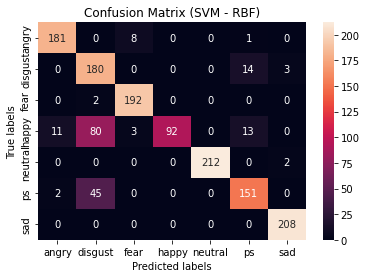

In [132]:
print(classification_report(y_test,predictions))

acc = float(accuracy_score(y_test,predictions))*100
print("----accuracy score %s ----" % acc)

cm = confusion_matrix(y_test,predictions)

ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax);

# labels, title and ticks
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix (SVM - RBF)'); 
ax.xaxis.set_ticklabels(tess_emotions);
ax.yaxis.set_ticklabels(tess_emotions);

In [133]:
audio_file_path = "/kaggle/input/manual-testing/AUDIO-2024-04-05-21-21-38.m4a"
audio_features = extract_feature(audio_file_path)
audio_features = audio_features.reshape(1, -1)
prediction = svclassifier.predict(audio_features)
print(prediction)

['fear']


In [134]:
audio_file_path = "/kaggle/input/manual-testing/AUDIO-2024-04-05-21-22-47.m4a"
audio_features = extract_feature(audio_file_path)
audio_features = audio_features.reshape(1, -1)
prediction = svclassifier.predict(audio_features)
print(prediction)

['disgust']


In [135]:
audio_file_path = "/kaggle/input/manual-testing/AUDIO-2024-04-05-21-22-33.m4a"
audio_features = extract_feature(audio_file_path)
audio_features = audio_features.reshape(1, -1)
prediction = svclassifier.predict(audio_features)
print(prediction)

['happy']


In [136]:
audio_file_path = "/kaggle/input/manual-testing/AUDIO-2024-04-05-21-21-38-1.m4a"
audio_features = extract_feature(audio_file_path)
audio_features = audio_features.reshape(1, -1)
prediction = svclassifier.predict(audio_features)
print(prediction)

['fear']


In [137]:
audio_file_path = "/kaggle/input/manual-testing/AUDIO-2024-04-05-02-26-31.m4a"
audio_features = extract_feature(audio_file_path)
audio_features = audio_features.reshape(1, -1)
prediction = svclassifier.predict(audio_features)
print(prediction)

['disgust']


In [138]:
audio_file_path = "/kaggle/input/manual-testing/AUDIO-2024-04-05-02-26-09.m4a"
audio_features = extract_feature(audio_file_path)
audio_features = audio_features.reshape(1, -1)
prediction = svclassifier.predict(audio_features)
print(prediction)

['happy']
